## The directories for various files is created using the following code

#### Here, the model that is used is a pretrained model fetched from tensorflow2 model zoo which has many kinds of object detection models. Out of various types of models, ssd mobilenet v2 fpn lite 320x320 is chosen by taking into account its speed (22ms) and accuracy (22.2 mAP). 

In [7]:
import os

In [8]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [9]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [10]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [ ]:
for path in paths.values():
    if not os.path.exists(path):
        !mkdir -p {path}

#### we are cloning the tensorflow repo consisting of all the models

In [ ]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

#### Now by running the following command, tensorflow's object detection model will be installed

In [1]:
!cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python3 -m pip install -I --user .

Processing /Users/sharath/Desktop/TFODCourse/Tensorflow/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Using cached avro-python3-1.10.2.tar.gz (38 kB)
  Using cached apache_beam-2.32.0-py3-none-any.whl
  Using cached Pillow-8.3.1-cp39-cp39-macosx_10_10_x86_64.whl (2.9 MB)
  Using cached lxml-4.6.3-cp39-cp39-macosx_10_9_x86_64.whl (4.6 MB)
  Using cached matplotlib-3.4.3-cp39-cp39-macosx_10_9_x86_64.whl (7.2 MB)
  Using cached Cython-0.29.24-cp39-cp39-macosx_10_9_x86_64.whl (1.9 MB)
  Using cached contextlib2-21.6.0-py2.py3-none-any.whl (13 kB)
^C
ERROR: Operation cancelled by user
You should consider upgrading via the '/Libra

#### Now that object detection model can be imported

In [11]:
import object_detection

#### saving the pretrained model in the allocated folder

In [ ]:
!wget {PRETRAINED_MODEL_URL}
!mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
!cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

#### This segment creates a label map

In [ ]:
labels = [{'name':'licence', 'id':1}]
with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

#### The following commands converts the test and train data into the tensorflow record format that could be used in the model

In [ ]:
!git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}

In [ ]:
!python3 {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python3 {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} 

#### By running the following command, we get a pipeline config file which contains the configurations for the model that could be finetuned as per our needs

In [ ]:
!cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

#### In this section, the following code finetunes the pipeline.config file according to our specifications

In [ ]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [ ]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [ ]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [ ]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [ ]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

#### So now we generate the command to train the model

In [5]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

NameError: name 'paths' is not defined

In [3]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=2000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

NameError: name 'TRAINING_SCRIPT' is not defined

In [ ]:
print(command)

#### we will get the command as 'python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_ssd_mobnet --pipeline_config_path=Tensorflow/workspace/models/my_ssd_mobnet/pipeline.config --num_train_steps=2000'.

#### Here the portion 'python Tensorflow/models/research/object_detection/model_main_tf2.py' specifies the model that we will be using, '--model_dir=Tensorflow/workspace/models/my_ssd_mobnet' specifies where our trained model should be saved, '--pipeline_config_path=Tensorflow/workspace/models/my_ssd_mobnet/pipeline.config' specifies the config file and '--num_train_steps=2000' specifies the number of steps , similar to epochs

#### Loading the model

In [12]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [13]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-3')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

2021-10-05 11:46:02.926107: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Now by giving an image of a car as the input (given in the IMAGE_PATH variable) , an output with a bounding box over the licence plate can be obtained

In [14]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [15]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [238]:
#IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'Screenshot 2021-09-28 at 7.47.26 PM.png')
IMAGE_PATH = '/Users/sharath/Desktop/TFODCourse/licence label/indian plates/Cars261.png'

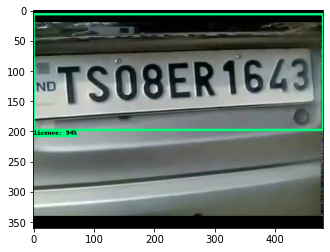

In [239]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

## Character identification and OCR

In [240]:
detection_threshold = 0.9

In [241]:
image = image_np_with_detections
scores = list(filter(lambda x : x > detection_threshold,detections['detection_scores']))
boxes = detections['detection_boxes'][:len(scores)]
classes = detections['detection_classes'][:len(scores)]

In [242]:
width = image.shape[1]
height = image.shape[0]

### Using cv2 contours and the ocr model that I did

In [40]:
import imutils
import matplotlib.gridspec as gridspec

In [41]:
for idx,box in enumerate(boxes):
    roi = box*[height,width,height,width]
    region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
plate_image = cv2.convertScaleAbs(region, alpha=(100.0))
    
# convert to grayscale and blur the image

gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray,(7,7),0)
    
# Applied inversed thresh_binary 
binary = cv2.threshold(blur, 180, 255,
                         cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
## Applied dilation 
kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)
thre_mor = cv2.cvtColor(thre_mor, cv2.COLOR_BGR2RGB)

edges = cv2.Canny(thre_mor,20,200)

contours = cv2.findContours(edges.copy(),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)
contours = sorted(contours,key=cv2.contourArea, reverse = True)
test_roi = region.copy()

digit_w, digit_h = 30, 60

crop_characters=[]
for c in contours:
    (x,y,w,h) = cv2.boundingRect(c)
    ratio = h/w
    if 1<=ratio<=9.5: # Only select contour with defined ratio
        if h/plate_image.shape[0]>=0.5: # Select contour which has the height larger than 50% of the plate
            # Draw bounding box arroung digit number
            cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)
            curr_num = thre_mor[y:y+h,x:x+w]
            curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
            #_, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            crop_characters.append(curr_num)

fig = plt.figure(figsize=(14,4))
grid = gridspec.GridSpec(ncols=len(crop_characters),nrows=1,figure=fig)

for i in range(len(crop_characters)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.imshow(crop_characters[i],cmap="gray")

ValueError: Number of columns must be a positive integer, not 0

<Figure size 1008x288 with 0 Axes>

In [18]:
import numpy as np
import imageio 
from keras.models import load_model

charac = []

for letters in crop_characters:
    ip = letters
    bandw = np.dot(ip[...,:3],[0.2989, 0.5870, 0.1140])
    #ip = (ip.reshape(1,28,28,1))/255

    model = load_model('ocr.h5')

    output = model.predict(ip)
    charac.append(output)
print(charac)

ValueError: in user code:

    /Users/sharath/Library/Python/3.9/lib/python/site-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /Users/sharath/Library/Python/3.9/lib/python/site-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/sharath/Library/Python/3.9/lib/python/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/sharath/Library/Python/3.9/lib/python/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/sharath/Library/Python/3.9/lib/python/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/sharath/Library/Python/3.9/lib/python/site-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_step(data)
    /Users/sharath/Library/Python/3.9/lib/python/site-packages/keras/engine/training.py:1537 predict_step
        return self(x, training=False)
    /Users/sharath/Library/Python/3.9/lib/python/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Users/sharath/Library/Python/3.9/lib/python/site-packages/keras/engine/input_spec.py:229 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: (None, 30, 3)


### Using pytesseract 

In [53]:
import pytesseract 
def ocR (image):
    im = image
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    threshold_img = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    customconfig = r'--oem 3 --psm 8'
    details = pytesseract.image_to_data(threshold_img, output_type=pytesseract.Output.DICT, config=customconfig, lang='eng')
    return threshold_img, details

['|', 'A', '|']


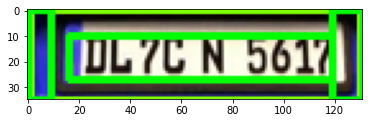

In [54]:
for idx,box in enumerate(boxes):
    roi = box*[height,width,height,width]
    region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
    test = region.copy()
    temp,details = ocR(test)
    totboxes = len(details['text'])
    #print(details)
    for i in range(totboxes):
        if(int(details['conf'][i]))>=30:
            (x,y,w,h) = (details['left'][i],details['top'][i],details['width'][i],details['height'][i])
            region = cv2.rectangle(region,(x,y),(x+w,y+h),(0,255,0),2)
    plt.imshow(region)
    #print(details)
    lic = []
    for texts in details['text']:
        if texts != '':
            lic.append(texts)
print(lic)

#### image processing for pytesseract

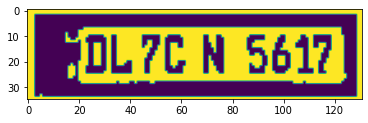

In [44]:
for idx,box in enumerate(boxes):
    roi = box*[height,width,height,width]
    region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
    result = np.zeros(region.shape, dtype=np.uint8)
    #hsv = cv2.cvtColor(region, cv2.COLOR_BGR2HSV)
#     lower = np.array([0,0,0])
#     upper = np.array([200,180,180])
#     mask = cv2.inRange(hsv, lower, upper)
    thres = cv2.cvtColor(region, cv2.COLOR_BGR2GRAY)
    thres = thres.astype(np.uint8)
    mask = cv2.threshold(thres, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    # Perform morph close and merge for 3-channel ROI extraction
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    close = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)
    extract = cv2.merge([close,close,close])

    # Find contours, filter using contour area, and extract using Numpy slicing
    cnts = cv2.findContours(close, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        area = w * h
        if area < 5000 and area > 2500:
            cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 3)
            result[y:y+h, x:x+w] = extract[y:y+h, x:x+w] 

    # Invert image and throw into Pytesseract
    invert = 255 - result
    plt.imshow(mask)

### Using easyocr

In [115]:
import easyocr
import string
reader = easyocr.Reader(['en'])

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [84]:
box_thres = 0.5

def numplatereg(image,result,img_thres):
    siz = region.shape[0]*region.shape[1]
    plate=[]
    for res in result:
        length = np.sum(np.subtract(result[0][0][1],result[0][0][0]))
        width = np.sum(np.subtract(result[0][0][2],result[0][0][1]))
        lol = (length*width)/siz
        if (length*width)/siz > img_thres:
            plate.append(res[1])
    return plate
        

License plate number :  ND
License plate number :  TSOBER1643


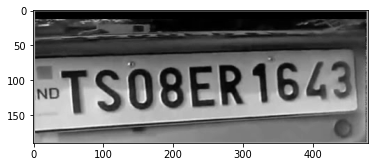

In [248]:
ocr_res=[]
for idx,box in enumerate(boxes):
    roi = box*[height,width,height,width]
    thres = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
    temp = thres
    thres = cv2.cvtColor(thres, cv2.COLOR_BGR2GRAY)
    thres = thres.astype(np.uint8)
    region = cv2.threshold(thres, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    
    #plt.imshow(region)
    op = reader.readtext(region,allowlist=string.ascii_uppercase + "0123456789")
    ocr_res.append(op)
    for i in range(0,len(ocr_res)):
        for j in range(0,len(ocr_res[i])):
            print('License plate number : ', ocr_res[i][j][1])

    plt.imshow(thres, cmap='gray')
    plt.show()

#### Analyzing the plate using indian number plate number format

In [251]:
numtolet={0:'O',4:'A',1:'I',5:'S',8:'B'}
lettonum={'O':0,'L':4,'I':1,'S':5,'B':8}
alpha=string.ascii_uppercase
numb = '0123456789'
test=''
for i in range(0,len(ocr_res)):
    if len(ocr_res[i])<1:
        continue
    for j in range(0,len(ocr_res[i])):
            
        if len(ocr_res[i][j])>1:
            test=test+ocr_res[i][j][1]
            if len(test) > 10:
                if test[:3] == 'IND':
                    test = test[3:]
                elif test[:2] == 'ND':
                    test = test[2:]
        else:
            test=ocr_res[i][j][1]
    l=list(test)
    if len(l)>10:
        l.pop()
    if l[0] in alpha and l[1] in alpha:
        pass
    elif not(l[1] in alpha) and l[0] in alpha:
        l[1]=numtolet[l[1]]
    elif not(l[0] in alpha) and l[1] in alpha :
        l[0]=numtolet[l[0]]
    else:
        l[1]=numtolet[l[1]]
        l[0]=numtolet[l[0]]


    if l[2] in numb and l[3] in numb:
        pass
    elif not(l[3] in numb) and l[2] in numb :
        l[3] = lettonum[l[3]]
    elif not(l[2] in numb) and l[3] in numb:
        l[2]=lettonum[l[2]]
    else:
        l[2]=lettonum[l[2]]
        l[3] = lettonum[l[3]]

    if l[4] in alpha and l[5] in alpha:
        pass
    elif not(l[5] in alpha) and l[4] in alpha :
        l[5]=numtolet[l[5]]
    elif not(l[4] in alpha) and l[5] in alpha:
        l[4]=numtolet[l[4]]
    else:
        l[5]=numtolet[l[5]]
        l[4]=numtolet[l[4]]

    if test[6] in numb and test[7] in numb and test[8] in numb and test[9] in numb :
        continue
    if not(test[6] in numb):
        l[6] = lettonum[l[6]]
    if not(test[7] in numb):
        l[7] = lettonum[l[7]]
    if not(test[8] in numb):
        l[8] = lettonum[l[8]]
    if not(test[9] in numb):
        l[9] = lettonum[l[9]]
print('license plate number :',str("".join(str(i) for i in l)))
            

license plate number : TS08ER1643


#### Trying out sharpening filter, inversion and eroding

License plate number :  TN07BJ
License plate number :  JL896


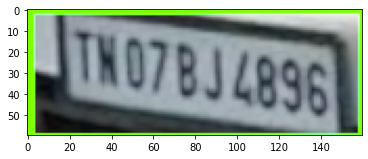

In [43]:
sharpening_filter= np.array([[0,-1,0],[-1,5,-1],[0,-1,-0]])
sharpening_image = cv2.filter2D(temp,-1,sharpening_filter)

inverte = cv2.bitwise_not(temp)

kernel = np.ones((1,1),np.uint8)
noise_img = cv2.dilate(temp,kernel,iterations=1)
kernel = np.ones((1,1),np.uint8)
noise_img = cv2.erode(noise_img,kernel,iterations=1)
noise_img = cv2.morphologyEx(noise_img, cv2.MORPH_CLOSE,kernel)
noise_img = cv2.medianBlur(noise_img,3)

erode_img= cv2.bitwise_not(temp)
kernel = np.ones((2,2),np.uint8)
erode_img = cv2.erode(erode_img, kernel, iterations=1)
erode_img = cv2.bitwise_not(erode_img)
ocr_res = reader.readtext(erode_img,allowlist=string.ascii_uppercase + "0123456789")
for i in range(0,len(ocr_res)):
    print('License plate number : ', ocr_res[i][1])
plt.imshow(erode_img)

#### Using a super resolution DL model to enhance the image

In [32]:
import cv2
sr = cv2.dnn_superres.DnnSuperResImpl_create()

path = "FSRCNN_x3.pb"

sr.readModel(path)

sr.setModel("edsr",3)

result = sr.upsample(temp)

# Resized image
resized = cv2.resize(temp,dsize=None,fx=4,fy=4)
plt.imshow(result)

[ERROR:0] global /private/var/folders/24/8k48jl6d249_n_qfxwsl6xvm0000gn/T/pip-req-build-8g_88acj/opencv/modules/dnn/src/dnn.cpp (3512) getLayerShapesRecursively OPENCV/DNN: [Convolution]:(conv1): getMemoryShapes() throws exception. inputs=1 outputs=0/1 blobs=1
[ERROR:0] global /private/var/folders/24/8k48jl6d249_n_qfxwsl6xvm0000gn/T/pip-req-build-8g_88acj/opencv/modules/dnn/src/dnn.cpp (3515) getLayerShapesRecursively     input[0] = [ 1 3 60 160 ]
[ERROR:0] global /private/var/folders/24/8k48jl6d249_n_qfxwsl6xvm0000gn/T/pip-req-build-8g_88acj/opencv/modules/dnn/src/dnn.cpp (3523) getLayerShapesRecursively     blobs[0] = CV_32FC1 [ 56 1 5 5 ]
[ERROR:0] global /private/var/folders/24/8k48jl6d249_n_qfxwsl6xvm0000gn/T/pip-req-build-8g_88acj/opencv/modules/dnn/src/dnn.cpp (3525) getLayerShapesRecursively Exception message: OpenCV(4.5.3) /private/var/folders/24/8k48jl6d249_n_qfxwsl6xvm0000gn/T/pip-req-build-8g_88acj/opencv/modules/dnn/src/layers/convolution_layer.cpp:387: error: (-215:Assert

error: OpenCV(4.5.3) /private/var/folders/24/8k48jl6d249_n_qfxwsl6xvm0000gn/T/pip-req-build-8g_88acj/opencv/modules/dnn/src/layers/convolution_layer.cpp:387: error: (-215:Assertion failed) ngroups > 0 && inpCn % ngroups == 0 && outCn % ngroups == 0 in function 'getMemoryShapes'


#### Normal PIL enhancer 

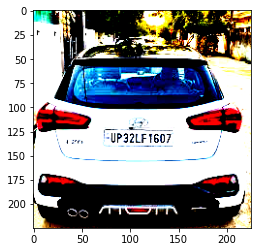

In [35]:
from PIL import Image, ImageEnhance 
im = Image.open("/Users/sharath/Desktop/TFODCourse/licence label/Cars454.png")
enhancer = ImageEnhance.Contrast(im)
enhanced_im = enhancer.enhance(4.0)
nim = np.array(enhanced_im)
plt.imshow(nim)

In [13]:
def pred(path):
    img = cv2.imread(path)
    image_np = np.array(img)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)
    return image_np_with_detections,detections

## Getting live detection using webcam of the laptop

In [18]:
vide = cv2.VideoCapture(0)
reader = easyocr.Reader(['en'])
while True:
    flag, image = vide.read()
    image_np = np.array(image)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)
    cv2.imshow('licence detection',image_np_with_detections)
    
    detection_threshold = 0.9
    
    image = image_np_with_detections
    scores = list(filter(lambda x : x > detection_threshold,detections['detection_scores']))
    boxes = detections['detection_boxes'][:len(scores)]
    classes = detections['detection_classes'][:len(scores)]
    
    width = image.shape[1]
    height = image.shape[0]
    
    for idx,box in enumerate(boxes):
        roi = box*[height,width,height,width]
        thres = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
        thres = cv2.cvtColor(thres, cv2.COLOR_BGR2GRAY)
        thres = thres.astype(np.uint8)
        region = cv2.adaptiveThreshold(thres,190,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,19,4)
        #plt.imshow(region)
        ocr_res = reader.readtext(region,allowlist=string.ascii_uppercase + "0123456789")
        for i in range(0,len(ocr_res)):
            print('licence plate number : ',ocr_res[i][1])
    
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
vide.release()
cv2.destroyAllWindows()

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


### Finding out the accuracy of the OCR model

In [22]:
from os import listdir
path = '/Users/sharath/Desktop/TFODCourse/licence label'
file = listdir(path)
detection_threshold = 0.9
reader = easyocr.Reader(['en'])
ocr_list={}
for i in range (len(file)):
    ocr_per_car = []
    name = file[i]
    ext = name.split('.')
    if len(ext) == 2:
        exttemp = ext[1]
        if name == '.DS_Store':
            pass
        elif exttemp != 'xml' :
            pathe='/Users/sharath/Desktop/TFODCourse/licence label'+'/'+name
            image,detections = pred(pathe)
            scores = list(filter(lambda x : x > detection_threshold,detections['detection_scores']))
            boxes = detections['detection_boxes'][:len(scores)]
            classes = detections['detection_classes'][:len(scores)]
            
            width = image.shape[1]
            height = image.shape[0]
            
            for idx,box in enumerate(boxes):
                roi = box*[height,width,height,width]
                thres = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
                thres = cv2.cvtColor(thres, cv2.COLOR_BGR2GRAY)
                thres = thres.astype(np.uint8)
                region = cv2.adaptiveThreshold(thres,190,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,17,4)
                #plt.imshow(region)
                
                ocr_res = reader.readtext(region,allowlist=string.ascii_uppercase + "0123456789")
                
                for i in range(0,len(ocr_res)):
                    ocr_per_car.append(ocr_res[i][1])
                ocr_list[name]=ocr_per_car
            

    elif len(ext) == 3:
        extempe = ext[2]
        if name == '.DS_Store':
            pass
        elif extempe != 'xml' :
            pathe='/Users/sharath/Desktop/TFODCourse/licence label'+'/'+name
            image,detections = pred(pathe)
            scores = list(filter(lambda x : x > detection_threshold,detections['detection_scores']))
            boxes = detections['detection_boxes'][:len(scores)]
            classes = detections['detection_classes'][:len(scores)]
            
            width = image.shape[1]
            height = image.shape[0]
            
            for idx,box in enumerate(boxes):
                roi = box*[height,width,height,width]
                thres = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
                thres = cv2.cvtColor(thres, cv2.COLOR_BGR2GRAY)
                thres = thres.astype(np.uint8)
                region = cv2.adaptiveThreshold(thres,190,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,17,4)
                #plt.imshow(region)
                ocr_res = reader.readtext(region,allowlist=string.ascii_uppercase + "0123456789")
                for i in range(0,len(ocr_res)):
                    ocr_per_car.append(ocr_res[i][1])
                ocr_list[name]=ocr_per_car
print(ocr_list)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


{'Cars53.png': ['CHIQOSE'], 'Cars366.png': ['MH208C20', 'L1'], 'Cars372.png': ['FKRZSCET4851'], 'Cars428.png': ['DZIZYXR'], 'Cars158.png': ['COSIALRICAF', '695299', 'CENTROAMERICA'], 'licence.2536a71c-0b2e-11ec-9b7c-acde48001122.jpg': ['AHD', 'OX65'], 'Cars212.png': ['KL85H4383'], 'licence.25368fc0-0b2e-11ec-9b7c-acde48001122.jpg': ['DZIZYXR'], 'Cars167.png': ['15HLK10898'], 'Cars198.png': ['FMHO1A88866S'], 'Cars97.png': ['KA05HG19091'], 'Cars176.png': ['DUK4C000IOWI', 'A', 'OCT', 'W', '82', 'EVQ9', 'OAD', 'EXV'], 'Cars389.png': ['44', 'EAB', '887'], 'Cars376.png': ['EEZZ28H1'], 'Cars438.png': ['MH47A7313'], 'licence.253936d0-0b2e-11ec-9b7c-acde48001122.jpg': ['HORS1EK'], 'licence.25324abe-0b2e-11ec-9b7c-acde48001122.jpg': ['BES', 'PUIB'], 'Cars107.png': ['MH208C20', 'L1'], 'Cars273.png': ['BRIT0001'], 'licence.2538ea72-0b2e-11ec-9b7c-acde48001122.jpg': ['80211N5', 'LIVID', 'VIRGINIA', 'OT'], 'Cars307.png': ['M96090K'], 'licence.2539f494-0b2e-11ec-9b7c-acde48001122.jpg': ['ALR486'], 'C

In [23]:
import csv
import Levenshtein

In [24]:
def concat(array):
    word = ''
    for i in range(0,len(array)):
        if i ==0:
            word = array[i]
        else:
            word=word+array[i]
    return word

def space_remove(string):
    fin =''
    for i in range(0,len(string)):
        if string[i]==' ':
            pass
        else:
            fin = fin + string[i]
    return fin

In [25]:
with open('licence_label.csv', 'r') as file:
    reader = csv.reader(file)
    positive_cases=0
    for row in reader:
        if row[0] == 'filename':
            pass
        else:
            l=list(row[3])
            fin = space_remove(l)
            img_name = row[0]
            try:
                plate=ocr_list[img_name]
                if len(plate) == 0:
                    print('No match.. actual,ocr:',row[3],',',plate)
                elif fin in plate:
                    print('Correct!! actual,ocr: ',row[3],',',plate,', word accuracy : 100 %') 
                    positive_cases = positive_cases +1
                else:
                    palte = concat(plate)
                    if row[3] == palte:
                        print('Correct!! actual,ocr: ',row[3],',',plate,', word accuracy : 100 %') 
                        positive_cases = positive_cases +1
                    elif Levenshtein.ratio(palte,row[3]) > 0:
                        print('Partially correct.. actual,ocr: ',row[3],',',plate,', word accuracy :',(Levenshtein.ratio(palte,row[3]))*100,'%')
                    else:
                        for i in range(0,len(plate)):
                            cur = plate[i]
                            if Levenshtein.ratio(cur,row[3])>0.6:
                                per=(Levenshtein.ratio(cur,row[3]))*100
                            
                        print('Partially correct.. actual,ocr: ',row[3],',',plate,', word accuracy :',per,'%')
            except:
                pass
print('correct ocr op : ',positive_cases)

Partially correct.. actual,ocr:  CHIO OSE , ['CHIQOSE'] , word accuracy : 80.0 %
Correct!! actual,ocr:  695299 , ['COSIALRICAF', '695299', 'CENTROAMERICA'] , word accuracy : 100 %
Partially correct.. actual,ocr:  DZI7YXR , ['DZIZYXR'] , word accuracy : 85.71428571428571 %
Partially correct.. actual,ocr:  HR26CE1485 , ['FKRZSCET4851'] , word accuracy : 54.54545454545454 %
Partially correct.. actual,ocr:  MH 20 BQ 20 , ['MH208C20', 'L1'] , word accuracy : 57.14285714285714 %
Partially correct.. actual,ocr:  KL65H4383 , ['KL85H4383'] , word accuracy : 88.88888888888889 %
Partially correct.. actual,ocr:  OX65AWD , ['AHD', 'OX65'] , word accuracy : 57.14285714285714 %
Partially correct.. actual,ocr:  DZI7YXR , ['DZIZYXR'] , word accuracy : 85.71428571428571 %
Partially correct.. actual,ocr:  15LK10898 , ['15HLK10898'] , word accuracy : 94.73684210526315 %
Partially correct.. actual,ocr:  MH01AV8866 , ['FMHO1A88866S'] , word accuracy : 72.72727272727273 %
Partially correct.. actual,ocr:  EV0

In [11]:
import tkinter as tk
from tkinter import ttk,Label,Canvas,Text
from tkinter import filedialog as fd
from PIL import Image, ImageTk


In [12]:
reader = easyocr.Reader(['en'])
detection_threshold = 0.9
def ocre(image,detections):
    scores = list(filter(lambda x : x > detection_threshold,detections['detection_scores']))
    boxes = detections['detection_boxes'][:len(scores)]
    classes = detections['detection_classes'][:len(scores)]
    
    width = image.shape[1]
    height = image.shape[0]
    
    for idx,box in enumerate(boxes):
        roi = box*[height,width,height,width]
        thres = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
        thres = cv2.cvtColor(thres, cv2.COLOR_BGR2GRAY)
        thres = thres.astype(np.uint8)
        region = cv2.adaptiveThreshold(thres,190,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,19,4)
        #plt.imshow(region)
        ocr_res = reader.readtext(region,allowlist=string.ascii_uppercase + "0123456789")
        return ocr_res

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [17]:
root = tk.Tk()
root.title('LPR')
root.resizable(1000,1000)
root['background']="#4c0099"
root.geometry('700x700')

def selected_file():
    filetype=(('jpg files','*.jpg'),('png files','*.png'))
    filename = fd.askopenfilename(title = 'select the file',filetypes = filetype)
    img,flag= pred(filename)
    ocr_res = ocre(img,flag)
    im = Image.fromarray(img)
    imgtk = ImageTk.PhotoImage(image=im)
    imge = Label(root, image=imgtk)
    imge.image = imgtk
    imge.place(x=150, y=200)
    for i in range(0,len(ocr_res)):
        a='licence plate number : '+ ocr_res[i][1]
        text.insert('1.0', a)
text = Text(root, height=8)
text.pack()
open_button = ttk.Button(root,text='Select the image',command=selected_file)

open_button.pack(expand=True)

root.mainloop()